In [1]:
# Colab: install Kaggle CLI + make folders
!pip -q install kaggle
import os, json, textwrap, pathlib

BASE = pathlib.Path(".")
RAW = BASE/"data"/"raw"
OUT = BASE/"results"/"outputs"
for p in [RAW, OUT]:
    p.mkdir(parents=True, exist_ok=True)

# 🔑 Upload kaggle.json when prompted (from your Kaggle account > Settings > API)
from google.colab import files
print("Upload your kaggle.json (from Kaggle > Settings > Create New API Token)")
uploaded = files.upload()

# Save creds with correct permissions
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "wb") as f:
    f.write(uploaded["kaggle.json"])
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

# Download dataset
!kaggle datasets download -d aakashpatil10/finance-default-prediction -p data/raw -o
!unzip -o -d data/raw data/raw/finance-default-prediction.zip


Upload your kaggle.json (from Kaggle > Settings > Create New API Token)


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/aakashpatil10/finance-default-prediction
License(s): apache-2.0
  0% 0.00/15.4k [00:00<?, ?B/s]
100% 15.4k/15.4k [00:00<00:00, 43.5MB/s]
Archive:  data/raw/finance-default-prediction.zip
  inflating: data/raw/finance_default_prediction.csv  


In [2]:
import pandas as pd, numpy as np, glob, os, re, matplotlib.pyplot as plt

# Pick the first CSV found (adjust if needed)
csvs = glob.glob(str(RAW/"*.csv"))
assert len(csvs)>0, "No CSVs found in data/raw."
CSV_NAME = csvs[0]
print("Using:", os.path.basename(CSV_NAME))

df = pd.read_csv(CSV_NAME)
print("Shape:", df.shape)
display(df.head(3))
df.info()


Using: finance_default_prediction.csv
Shape: (1000, 8)


,CustomerID,Age,AnnualIncome,LoanAmount,CreditScore,LoanTerm,ExistingDebt,Default
0,1,21,80448,27761,817,36,10975,0
1,2,57,49434,41546,828,36,35616,1
2,3,55,101896,41712,497,60,22864,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   CustomerID    1000 non-null   int64
 1   Age           1000 non-null   int64
 2   AnnualIncome  1000 non-null   int64
 3   LoanAmount    1000 non-null   int64
 4   CreditScore   1000 non-null   int64
 5   LoanTerm      1000 non-null   int64
 6   ExistingDebt  1000 non-null   int64
 7   Default       1000 non-null   int64
dtypes: int64(8)
memory usage: 62.6 KB


Guessed TARGET: Default
Counts:
 Default
0    385
1    615
Name: count, dtype: int64
Ratios:
 Default
neg(0)    0.385
pos(1)    0.615
Name: count, dtype: float64


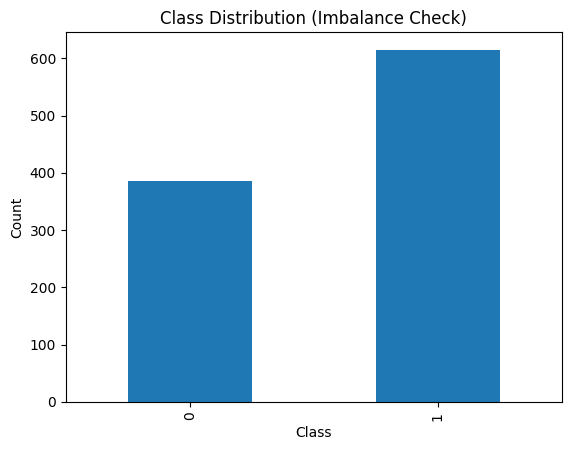

In [3]:
# Try to infer the target column name
candidates = [c for c in df.columns if re.search(r'(default|defaulter|loan_default|is_default|target|label)', c, re.I)]
TARGET = candidates[0] if candidates else None
print("Guessed TARGET:", TARGET)
# If wrong, set manually, e.g.:
# TARGET = "default"

assert TARGET in df.columns, "Set TARGET manually to your binary target column."

# Ensure binary numeric (0/1)
y_raw = df[TARGET]
if not set(np.unique(y_raw.dropna())).issubset({0,1}):
    # Try to coerce (e.g., 'Yes'/'No', 'Y'/'N')
    mapping = {'yes':1,'y':1,'true':1,'t':1,'default':1,
               'no':0,'n':0,'false':0,'f':0,'non-default':0}
    y = y_raw.astype(str).str.lower().map(mapping)
    if y.isna().mean()<0.05:
        df[TARGET] = y.astype(int)
    else:
        raise ValueError("Target not binary—please clean/encode it first.")

# Class ratio
class_counts = df[TARGET].value_counts().sort_index()
class_ratio = (class_counts / class_counts.sum()).rename({0:"neg(0)", 1:"pos(1)"})
print("Counts:\n", class_counts)
print("Ratios:\n", class_ratio.round(4))

# Simple bar to show imbalance
ax = class_counts.plot(kind="bar")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
ax.set_title("Class Distribution (Imbalance Check)")
plt.show()


In [10]:
# Balance full df so class 0 and 1 have equal counts
!pip -q install imbalanced-learn

import pandas as pd, numpy as np, pathlib
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# --- settings ---
TARGET = "Default"   # change if your target column name differs
SAVE = pathlib.Path("results/outputs"); SAVE.mkdir(parents=True, exist_ok=True)

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

print("Before:", y.value_counts().to_dict())

# 1) Oversample minority to match majority (more rows)
ros = RandomOverSampler(random_state=42)             # sampling_strategy='auto' -> minority up to majority
X_over, y_over = ros.fit_resample(X, y)
df_over = pd.concat([pd.DataFrame(X_over, columns=X.columns),
                     pd.Series(y_over, name=TARGET)], axis=1)
df_over.to_csv(SAVE/"df_balanced_over.csv", index=False)
print("After (oversample):", df_over[TARGET].value_counts().to_dict())

# 2) Undersample majority to match minority (fewer rows)
rus = RandomUnderSampler(random_state=42)            # sampling_strategy='auto' -> majority down to minority
X_under, y_under = rus.fit_resample(X, y)
df_under = pd.concat([pd.DataFrame(X_under, columns=X.columns),
                      pd.Series(y_under, name=TARGET)], axis=1)
df_under.to_csv(SAVE/"df_balanced_under.csv", index=False)
print("After (undersample):", df_under[TARGET].value_counts().to_dict())

print("Saved:", SAVE/"df_balanced_over.csv", "and", SAVE/"df_balanced_under.csv")


Before: {1: 615, 0: 385}
After (oversample): {0: 615, 1: 615}
After (undersample): {0: 385, 1: 385}
Saved: results/outputs/df_balanced_over.csv and results/outputs/df_balanced_under.csv


Saved: results/outputs/df_balanced_over.csv and results/outputs/df_balanced_under.csv

[oversample] counts: {0: 615, 1: 615}


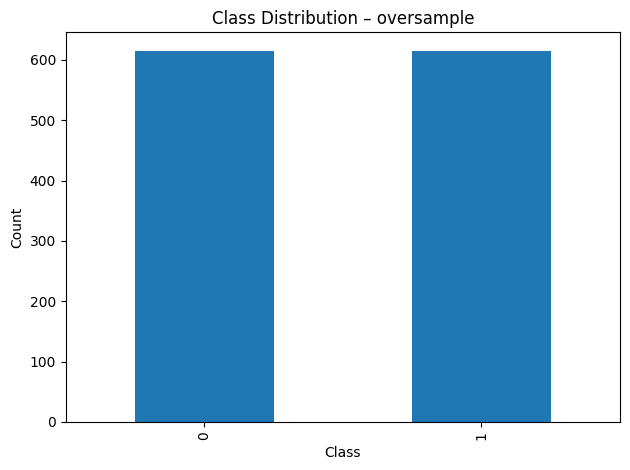


[undersample] counts: {0: 385, 1: 385}


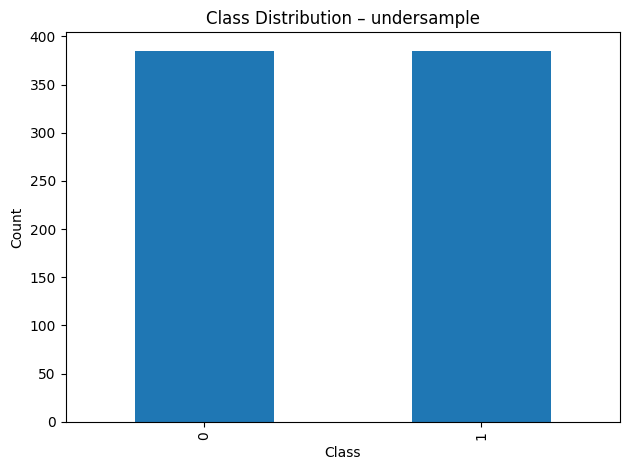

In [12]:
# --- Oversample & Undersample WHOLE df, then check imbalance ---
!pip -q install imbalanced-learn

import pandas as pd, numpy as np, pathlib, matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

TARGET = "Default"  # ← change if your target column name is different
SAVE = pathlib.Path("results/outputs"); SAVE.mkdir(parents=True, exist_ok=True)
VIS  = pathlib.Path("results/eda_visualizations"); VIS.mkdir(parents=True, exist_ok=True)

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# 1) Oversample minority → match majority
ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X, y)
df_over = pd.concat([pd.DataFrame(X_over, columns=X.columns),
                     pd.Series(y_over, name=TARGET)], axis=1)
df_over.to_csv(SAVE/"df_balanced_over.csv", index=False)

# 2) Undersample majority → match minority
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X, y)
df_under = pd.concat([pd.DataFrame(X_under, columns=X.columns),
                      pd.Series(y_under, name=TARGET)], axis=1)
df_under.to_csv(SAVE/"df_balanced_under.csv", index=False)

print("Saved:", SAVE/"df_balanced_over.csv", "and", SAVE/"df_balanced_under.csv")

# --- Re-check imbalance (only these two) ---
for name, d in [("oversample", df_over), ("undersample", df_under)]:
    vc = d[TARGET].value_counts().sort_index()
    print(f"\n[{name}] counts:", vc.to_dict())
    ax = vc.plot(kind="bar")
    ax.set_title(f"Class Distribution – {name}")
    ax.set_xlabel("Class"); ax.set_ylabel("Count")
    plt.tight_layout()
    plt.savefig(VIS/f"class_dist_{name}.png", dpi=160)
    plt.show()


In [13]:
import re, glob, os, pathlib, pandas as pd, numpy as np

SAVE = pathlib.Path("results/outputs"); SAVE.mkdir(parents=True, exist_ok=True)

# If you already set TARGET/DATE_COL earlier, this will reuse them.
# Otherwise we try to guess TARGET; and try to find a date column.
if 'TARGET' not in globals():
    guesses = [c for c in df.columns if re.search(r'(default|defaulter|loan_default|is_default|target|label)', c, re.I)]
    TARGET = guesses[0] if guesses else None
print("TARGET =", TARGET)

# Set manually if guess is wrong:
# TARGET = "Default"  # <-- uncomment & edit if needed

assert TARGET in df.columns, "Please set TARGET to your binary target column name."

# Try to find a date column if not set
if 'DATE_COL' not in globals() or DATE_COL is None:
    date_candidates = []
    for c in df.columns:
        if re.search(r'(date|time|month|year|timestamp)', c, re.I):
            try:
                pd.to_datetime(df[c], errors="raise")
                date_candidates.append(c)
            except:
                pass
    DATE_COL = date_candidates[0] if date_candidates else None
print("DATE_COL =", DATE_COL)

# make sure target is 0/1 integers
df[TARGET] = df[TARGET].astype(int)


TARGET = Default
DATE_COL = None


In [15]:
# == CONFIG ==
TARGET = "Default"          # <-- set to your target column name
DATE_COL = None             # <-- set like "application_date" if you know it; else we'll try to auto-detect
BALANCE_METHOD = "over"     # "over" or "under"
TEST_FRAC = 0.15
VAL_FRAC  = 0.15
RANDOM_STATE = 42

# == IMPORTS ==
!pip -q install imbalanced-learn
import re, pathlib, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

SAVE_DIR = pathlib.Path("results/outputs"); SAVE_DIR.mkdir(parents=True, exist_ok=True)

# == 0) Sanity: find TARGET / DATE ==
if TARGET not in df.columns:
    guesses = [c for c in df.columns if re.search(r'(default|defaulter|loan_default|is_default|target|label)', c, re.I)]
    assert guesses, "TARGET not in df; set TARGET to your label column."
    TARGET = guesses[0]

if DATE_COL is None:
    # try to find a parseable date column
    cands = []
    for c in df.columns:
        if re.search(r'(date|time|month|year|timestamp)', c, re.I):
            try:
                pd.to_datetime(df[c], errors="raise")
                cands.append(c)
            except:
                pass
    DATE_COL = cands[0] if cands else None

print("TARGET  :", TARGET)
print("DATE_COL:", DATE_COL)

# ensure binary ints 0/1
df[TARGET] = df[TARGET].astype(int)

# == helper for logging ==
def brief(y, name):
    vc = y.value_counts().sort_index()
    r = (vc / vc.sum()).to_dict()
    print(f"{name:>6} | n={len(y):>5} | 0={vc.get(0,0):>5} 1={vc.get(1,0):>5} | pos_ratio={r.get(1,0):.4f}")

# == 1) Split: temporal if DATE_COL else stratified ==
X = df.drop(columns=[TARGET])
y = df[TARGET]

if DATE_COL:
    dfx = df[[DATE_COL, TARGET]].copy()
    dfx[DATE_COL] = pd.to_datetime(dfx[DATE_COL], errors="coerce")
    order = dfx[DATE_COL].sort_values().index

    n = len(order)
    n_test = int(round(n * TEST_FRAC))
    n_val  = int(round(n * VAL_FRAC))

    test_idx  = order[-n_test:]
    val_idx   = order[-(n_test+n_val):-n_test]
    train_idx = order[:-(n_test+n_val)]

    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_val,   y_val   = X.loc[val_idx],   y.loc[val_idx]
    X_test,  y_test  = X.loc[test_idx],  y.loc[test_idx]
else:
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=TEST_FRAC, stratify=y, random_state=RANDOM_STATE
    )
    # we want overall 15% val; from the remaining (1-TEST_FRAC) block, the share is:
    val_share_in_temp = VAL_FRAC / (1 - TEST_FRAC)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_share_in_temp, stratify=y_temp, random_state=RANDOM_STATE
    )

print("\nBefore balancing (class ratios):")
brief(y_train, "train")
brief(y_val,   "val")
brief(y_test,  "test")

# == 2) Balance TRAIN ONLY ==
if BALANCE_METHOD.lower() == "over":
    balancer = RandomOverSampler(random_state=RANDOM_STATE)
    suffix = "over"
elif BALANCE_METHOD.lower() == "under":
    balancer = RandomUnderSampler(random_state=RANDOM_STATE)
    suffix = "under"
else:
    raise ValueError("BALANCE_METHOD must be 'over' or 'under'.")

X_train_bal, y_train_bal = balancer.fit_resample(X_train, y_train)

print("\nAfter balancing TRAIN (1:1):")
brief(pd.Series(y_train_bal), "train*")

# == 3) Save outputs ==
train_df = X_train.copy(); train_df[TARGET] = y_train.values
val_df   = X_val.copy();   val_df[TARGET]   = y_val.values
test_df  = X_test.copy();  test_df[TARGET]  = y_test.values
train_bal_df = pd.DataFrame(X_train_bal, columns=X_train.columns)
train_bal_df[TARGET] = y_train_bal

paths = {
    "train_split.csv": train_df,
    "val_split.csv":   val_df,
    "test_split.csv":  test_df,
    f"train_balanced_{suffix}.csv": train_bal_df
}
for fname, d in paths.items():
    p = SAVE_DIR / fname
    d.to_csv(p, index=False)
    print("Saved:", p)


TARGET  : Default
DATE_COL: None

Before balancing (class ratios):
 train | n=  700 | 0=  269 1=  431 | pos_ratio=0.6157
   val | n=  150 | 0=   58 1=   92 | pos_ratio=0.6133
  test | n=  150 | 0=   58 1=   92 | pos_ratio=0.6133

After balancing TRAIN (1:1):
train* | n=  862 | 0=  431 1=  431 | pos_ratio=0.5000
Saved: results/outputs/train_split.csv
Saved: results/outputs/val_split.csv
Saved: results/outputs/test_split.csv
Saved: results/outputs/train_balanced_over.csv


In [16]:
import pandas as pd
t = pd.read_csv("results/outputs/train_balanced_over.csv")
t["Default"].value_counts()


,count
Default,
0,431
1,431
